In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
def init_worker(table):
    global shared_table
    shared_table = table

In [3]:
def process_indicator(data, indicator_name):
    # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
    long_df = data.stack(dropna = True).reset_index()
    # 重命名列：股票ID、时间、指标值
    long_df.columns = ['stock_id', 'time', 'value']
    # 添加指标类型列（如'post'、'high'）
    long_df['indicator'] = indicator_name
    return long_df

In [4]:
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
next_uplimit_data = (ff.read('up_limit') * post_data * ff.filter0).shift(-1,axis = 1)
next_open_data = (ff.read('open') * post_data * ff.filter0).shift(-1,axis = 1)
vol_data = ff.read('vol') * ff.filter0

df_vol = process_indicator(vol_data, 'vol')
df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_next_uplimit = process_indicator(next_uplimit_data, 'next_uplimit')
df_next_open = process_indicator(next_open_data, 'next_open')

long_table = pd.concat(
    [df_high, df_low, df_close, df_open, df_next_uplimit,df_next_open,df_vol],
    ignore_index=True
)
long_table['time'] = pd.to_datetime(long_table['time'])
init_worker(long_table)

In [5]:
stock_list = long_table['stock_id'].unique().tolist()

In [6]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak_high peak_low
    # 创建peak列，默认值为NaN
    '''
    
    df['peak_high'] = False
    df['peak_low'] = False
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak_high'] = True
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak_low'] = True
    
    return df

In [201]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点和平台长度
    """
    # 创建platform列，默认值为NaN
    df['platform_high'] = np.nan
    df['platform_low'] = np.nan
    df['platform_length'] = np.nan
    df['platform_volatility_highlow'] = np.nan
    df['platform_volatility_open'] = np.nan
    df['average_vol'] = np.nan
    df['vol_trend'] = np.nan
    df['increase'] = np.nan
    df['increase_validity'] = np.nan
    df['daily_return'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peakhigh_col = df.columns.get_loc('peak_high')
    peaklow_col = df.columns.get_loc('peak_low')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            
            if df.iloc[j,peakhigh_col]:
                current_high_low = df.iloc[j, low_col]
            if df.iloc[j,peaklow_col]:
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                platform_high = df.iloc[j:i, high_col].max()
                platform_low = df.iloc[j:i, low_col].min()
                df.iloc[i, df.columns.get_loc('platform_high')] = platform_high
                df.iloc[i, df.columns.get_loc('platform_low')] = platform_low
                df.iloc[i, df.columns.get_loc('platform_volatility_highlow')] = platform_high / platform_low - 1
                df.iloc[i, df.columns.get_loc('platform_volatility_open')] = df.iloc[i - 1]['open'] / df.iloc[j]['open']
                df.iloc[i, df.columns.get_loc('platform_length')] = i - j
                df.iloc[i, df.columns.get_loc('average_vol')] = df.iloc[j:i]['vol'].mean()
                df.iloc[i, df.columns.get_loc('vol_trend')] = df.iloc[(i + j - 1) // 2 + 1:i]['vol'].mean() / df.iloc[j:(i + j - 1) // 2]['vol'].mean()
                df.iloc[i, df.columns.get_loc('increase')] = df.iloc[i]['close'] / df.iloc[i]['open']
                df.iloc[i, df.columns.get_loc('increase_validity')] = df.iloc[i]['high'] / platform_high
                try:
                    daily_ret = (df.iloc[i + 3]['close'] - df.iloc[i + 2]['open']) / (2 * df.iloc[i + 2]['open'])    ##日均收益率
                except:
                    daily_ret = None
                df.iloc[i, df.columns.get_loc('daily_return')] = daily_ret
                break  # 找到平台后跳出内层循环
    
    return df

In [85]:
def stock_process(stock_id,start_date = '2010-01-03',end_date = '2026'):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：stock_id对应的所有连续突破信号df以及相关信息
    df = shared_table[shared_table['stock_id'] == stock_id]
    if df.empty:
        return pd.DataFrame(columns=['time', 'stock_id','platform_length','platform_volatility_highlow',
                                     'platform_volatility_open', 'vol_trend','vol_rate','increase','increase_validity'])
    else:
        stock_data = df.pivot(index='time',
                            columns='indicator',
                            values='value')
        stock_data.index = pd.to_datetime(stock_data.index)
        
        stock_data = climax_find(stock_data)
        stock_data = platform_find(stock_data)
        
        stock_data = stock_data[(stock_data.index >= start_date) & (stock_data.index <= end_date) & (stock_data['platform_length'].notna())]
        stock_data['breakthrough'] = stock_data['high'] > stock_data['platform_high']
        stock_data['vol_rate'] = stock_data['vol'] / stock_data['average_vol']
        stock_data = stock_data[stock_data['next_uplimit'] != stock_data['next_open']]
        result = stock_data[stock_data['breakthrough']]
        result_df = pd.DataFrame({
            'time': result.index,
            'stock_id': stock_id,
            'platform_length':result['platform_length'],
            'platform_volatility_highlow':result['platform_volatility_highlow'],
            'platform_volatility_open':result['platform_volatility_open'],
            'vol_trend':result['vol_trend'],
            'vol_rate':result['vol_rate'],
            'increase':result['increase'],
            'increase_validity':result['increase_validity'],
            'daily_return':result['daily_return']
        })
        
        return result_df.reset_index(drop = True)

In [86]:
stock_process('000001.SZ')

,time,stock_id,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity,daily_return
0,2010-10-11,000001.SZ,6.0,0.051521,NaN,1.386889,4.459278,1.041570,1.083825,0.013289
1,2010-10-13,000001.SZ,2.0,0.060046,1.042725,NaN,1.222176,1.030573,1.010349,0.013405
2,2010-10-14,000001.SZ,3.0,0.071016,1.038684,0.945004,1.382837,0.983378,1.039892,0.026648
3,2010-10-15,000001.SZ,4.0,0.113741,1.076790,1.046709,1.469745,1.052198,1.004666,0.003866
4,2010-10-18,000001.SZ,5.0,0.118938,1.050808,1.607464,1.234499,0.988144,1.035088,0.009153
...,...,...,...,...,...,...,...,...,...,...
736,2025-07-04,000001.SZ,5.0,0.051839,0.996766,0.513725,1.227541,1.020243,1.011129,0.003571
737,2025-07-07,000001.SZ,6.0,0.063545,0.998383,0.647333,0.996208,1.014286,1.007862,0.003529
738,2025-07-08,000001.SZ,7.0,0.071906,1.018593,0.776210,0.727186,0.995294,1.001560,0.020537
739,2025-07-09,000001.SZ,8.0,0.073579,1.030719,0.738407,0.832202,1.014218,1.004673,0.003510


In [143]:
t = stock_process('000001.SZ')

In [144]:
t[t['time'] > '2020']

,time,stock_id,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity,daily_return
462,2020-01-02,000001.SZ,3.0,0.051553,1.002420,0.675676,1.685285,1.013213,1.001181,0.003837
463,2020-01-03,000001.SZ,4.0,0.052795,1.007260,1.071709,1.049494,1.014168,1.021239,0.004115
464,2020-01-06,000001.SZ,5.0,0.075155,1.024803,1.310407,0.802623,1.003527,1.001733,-0.013719
465,2020-02-11,000001.SZ,4.0,0.041259,0.994517,0.759145,1.139326,1.013014,1.003358,-0.004733
466,2020-02-14,000001.SZ,7.0,0.044755,1.008225,0.969231,1.255466,1.018983,1.013387,0.005319
...,...,...,...,...,...,...,...,...,...,...
736,2025-07-04,000001.SZ,5.0,0.051839,0.996766,0.513725,1.227541,1.020243,1.011129,0.003571
737,2025-07-07,000001.SZ,6.0,0.063545,0.998383,0.647333,0.996208,1.014286,1.007862,0.003529
738,2025-07-08,000001.SZ,7.0,0.071906,1.018593,0.776210,0.727186,0.995294,1.001560,0.020537
739,2025-07-09,000001.SZ,8.0,0.073579,1.030719,0.738407,0.832202,1.014218,1.004673,0.003510


In [202]:
with Pool(96, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total = len(stock_list)))  ##一个list 元素是每支股票的所有信号

final_df_1 = pd.concat(res_lst, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████| 5105/5105 [10:29<00:00,  8.11it/s]


In [203]:
final_df_1

,time,stock_id,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity,daily_return
0,2010-10-11,000001.SZ,6.0,0.051521,NaN,1.386889,4.459278,1.041570,1.083825,0.009728
1,2010-10-13,000001.SZ,2.0,0.060046,1.042725,NaN,1.222176,1.030573,1.010349,0.026648
2,2010-10-14,000001.SZ,3.0,0.071016,1.038684,0.945004,1.382837,0.983378,1.039892,0.003866
3,2010-10-15,000001.SZ,4.0,0.113741,1.076790,1.046709,1.469745,1.052198,1.004666,0.009153
4,2010-10-18,000001.SZ,5.0,0.118938,1.050808,1.607464,1.234499,0.988144,1.035088,-0.007833
...,...,...,...,...,...,...,...,...,...,...
2326859,2025-06-03,689009.SH,2.0,0.049211,0.992403,NaN,1.127424,1.014934,1.006849,-0.028944
2326860,2025-06-23,689009.SH,3.0,0.056407,0.989992,0.944503,1.525807,0.977955,1.000165,-0.013343
2326861,2025-07-03,689009.SH,8.0,0.052549,0.976297,0.875197,1.588589,1.049898,1.017631,-0.009064
2326862,2025-07-14,689009.SH,3.0,0.031738,0.985054,0.683995,1.027485,1.023785,1.011430,-0.011947


In [194]:
def calculate_average_return(group):
    """
    对单个时间分组进行处理：
    1. 筛选platform_volatility_open的前30%
    2. 从中选择increase_validity最小的10只股票
    3. 计算这些股票的daily_return平均值
    """
    # 1. 计算platform_volatility_open的30%分位数（前30%即小于等于该值）
    vol_threshold = group['platform_volatility_open'].quantile(0.2)
    # 筛选出前30%的股票
    top30_vol = group[group['platform_volatility_open'] <= vol_threshold]
    # 处理样本不足的情况
    if len(top30_vol) < 10:
        # 若不足10只，返回现有样本的均值（或NaN）
        return top30_vol['daily_return'].mean()
    
    # 2. 按increase_validity升序排序，取最小的10只
    top10_lowest = top30_vol.sort_values('increase_validity').head(10)
    
    # 3. 计算平均daily_return
    return top10_lowest['daily_return'].mean()

In [182]:
final_df

,time,stock_id,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity,daily_return
0,2020-01-03,000001.SZ,4.0,0.052795,1.007260,1.071709,1.049494,1.014168,1.021239,0.004115
1,2020-01-06,000001.SZ,5.0,0.075155,1.024803,1.310407,0.802623,1.003527,1.001733,-0.013719
2,2020-02-11,000001.SZ,4.0,0.041259,0.994517,0.759145,1.139326,1.013014,1.003358,-0.004733
3,2020-02-14,000001.SZ,7.0,0.044755,1.008225,0.969231,1.255466,1.018983,1.013387,0.005319
4,2020-02-17,000001.SZ,8.0,0.058741,1.010966,1.041834,1.241762,1.021941,1.015192,-0.002935
...,...,...,...,...,...,...,...,...,...,...
1181054,2025-06-03,689009.SH,2.0,0.049211,0.992403,NaN,1.127424,1.014934,1.006849,-0.004110
1181055,2025-06-23,689009.SH,3.0,0.056407,0.989992,0.944503,1.525807,0.977955,1.000165,0.000339
1181056,2025-07-03,689009.SH,8.0,0.052549,0.976297,0.875197,1.588589,1.049898,1.017631,-0.019416
1181057,2025-07-14,689009.SH,3.0,0.031738,0.985054,0.683995,1.027485,1.023785,1.011430,-0.002022


In [204]:
test_df = final_df_1.groupby('time')
average_returns = test_df.apply(calculate_average_return)
all_returns = test_df['daily_return'].mean()

In [164]:
def calculate_and_plot_cumulative_return(daily_returns,all_returns):
    """
    计算累计收益率并绘制折线图
    
    参数：
        daily_returns (pd.Series)：包含每日收益率的 Series，索引建议为时间序列
    
    返回：
        cumulative_returns (pd.Series)：累计收益率 Series
    """
    # 计算累计收益率，假设初始资金为 1，累计收益率计算公式：(1 + 每日收益率).cumprod() - 1
    daily_returns.index = pd.to_datetime(daily_returns.index)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    cumulative_returns_all = (1 + all_returns).cumprod() - 1
    excess_return = cumulative_returns - cumulative_returns_all
    # 绘制累计收益率折线图
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot(title='Cumulative Returns Over Time', label='Cumulative Strategy Returns')
    cumulative_returns_all.plot(title='Cumulative Returns Over Time', label='Cumulative Market Returns')
    excess_return.plot(title='Cumulative Returns Over Time', label='Excess Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return cumulative_returns

In [172]:
def calculate_and_plot_cumulative_return_log(daily_returns,all_returns):
    """
    计算累计收益率并绘制折线图
    
    参数：
        daily_returns (pd.Series)：包含每日收益率的 Series，索引建议为时间序列
    
    返回：
        cumulative_returns (pd.Series)：累计收益率 Series
    """
    # 计算累计收益率，假设初始资金为 1，累计收益率计算公式：(1 + 每日收益率).cumprod() - 1
    daily_returns.index = pd.to_datetime(daily_returns.index)
    cumulative_returns = np.log(1 + daily_returns).cumsum()
    cumulative_returns_all = np.log(1 + all_returns).cumsum()
    excess_return = cumulative_returns - cumulative_returns_all
    # 绘制累计收益率折线图
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot(title='Cumulative Returns Over Time', label='Cumulative Strategy Returns')
    cumulative_returns_all.plot(title='Cumulative Returns Over Time', label='Cumulative Market Returns')
    excess_return.plot(title='Cumulative Returns Over Time', label='Excess Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return cumulative_returns

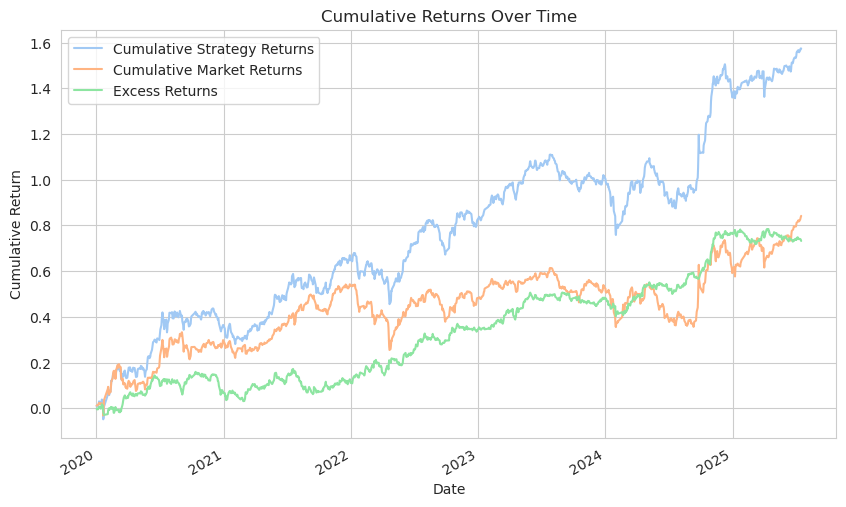

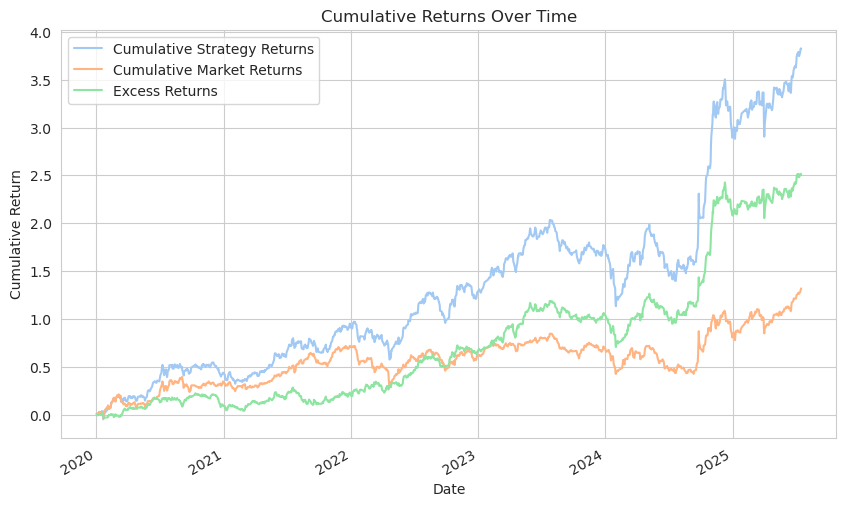

time
2020-01-02    0.010447
2020-01-03    0.006870
2020-01-06    0.010883
2020-01-07    0.016585
2020-01-08    0.020811
                ...   
2025-07-16    3.827423
2025-07-17    3.824514
2025-07-18         NaN
2025-07-21         NaN
2025-07-22         NaN
Length: 1345, dtype: float64

In [207]:
calculate_and_plot_cumulative_return_log(average_returns[average_returns.index > '2020'],all_returns[all_returns.index > '2020'])
calculate_and_plot_cumulative_return(average_returns[average_returns.index > '2020'],all_returns[all_returns.index > '2020'])

In [200]:
average_returns[average_returns.index > '2020'].head(50)

time
2020-01-02    0.003839
2020-01-03    0.018348
2020-01-06    0.003167
2020-01-07    0.009566
2020-01-08    0.006810
2020-01-09    0.006964
2020-01-10    0.012491
2020-01-13   -0.008304
2020-01-14   -0.001309
2020-01-15   -0.000293
2020-01-16    0.007695
2020-01-17    0.009756
2020-01-20    0.001397
2020-01-21   -0.015879
2020-01-22   -0.047700
2020-01-23    0.002423
2020-02-03    0.032071
2020-02-04    0.035193
2020-02-05    0.017824
2020-02-06   -0.011624
2020-02-07   -0.001436
2020-02-10    0.007145
2020-02-11   -0.001995
2020-02-12   -0.000318
2020-02-13    0.025128
2020-02-14    0.015834
2020-02-17    0.010017
2020-02-18    0.000831
2020-02-19    0.007796
2020-02-20   -0.003568
2020-02-21    0.013911
2020-02-24    0.003147
2020-02-25   -0.009270
2020-02-26   -0.031817
2020-02-27    0.011992
2020-02-28    0.032662
2020-03-02   -0.006183
2020-03-03    0.017500
2020-03-04    0.006643
2020-03-05   -0.015204
2020-03-06   -0.003214
2020-03-09    0.012014
2020-03-10   -0.000643
2020-0

In [67]:
percentile_80 = final_df['increase_validity'].quantile(0.7)
percentile_20 = final_df['increase_validity'].quantile(0.3)
df_test_increase = final_df[final_df['increase_validity'] > percentile_80]
df_test_decrease = final_df[final_df['increase_validity'] < percentile_20]

In [68]:
df_test_increase.corr()['daily_return']

platform_length               -0.025291
platform_volatility_highlow   -0.052906
platform_volatility_open      -0.053381
vol_trend                     -0.023666
vol_rate                      -0.029541
increase                      -0.022971
increase_validity             -0.061338
daily_return                   1.000000
Name: daily_return, dtype: float64

In [69]:
df_test_decrease.corr()['daily_return']

platform_length                0.008253
platform_volatility_highlow    0.017164
platform_volatility_open       0.001352
vol_trend                      0.010988
vol_rate                       0.017897
increase                       0.003241
increase_validity              0.008670
daily_return                   1.000000
Name: daily_return, dtype: float64

In [71]:
for i in final_df.columns[2:]:
    percentile_80 = final_df[i].quantile(0.8)
    percentile_20 = final_df[i].quantile(0.2)
    df_test_increase = final_df[final_df[i] > percentile_80]
    df_test_decrease = final_df[final_df[i] < percentile_20]
    print(i)
    print(df_test_increase.corr()['daily_return'])
    print(df_test_decrease.corr()['daily_return'])
    print('\n')

platform_length
platform_length                0.009034
platform_volatility_highlow   -0.049261
platform_volatility_open      -0.060177
vol_trend                     -0.038838
vol_rate                      -0.043687
increase                      -0.027030
increase_validity             -0.092734
daily_return                   1.000000
Name: daily_return, dtype: float64
platform_length                     NaN
platform_volatility_highlow    0.013038
platform_volatility_open      -0.001092
vol_trend                           NaN
vol_rate                      -0.003035
increase                      -0.002032
increase_validity              0.030261
daily_return                   1.000000
Name: daily_return, dtype: float64


platform_volatility_highlow
platform_length               -0.010067
platform_volatility_highlow   -0.035082
platform_volatility_open      -0.045686
vol_trend                     -0.022423
vol_rate                      -0.042139
increase                      -0.026227
incr